# AURORA 

## Setup

In [1]:
!pip install brainles_aurora matplotlib

%load_ext autoreload
%autoreload 2

  Using cached auxiliary-0.0.40-py3-none-any.whl.metadata (1.2 kB)
  Using cached nibabel-5.2.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached path-16.9.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached pillow-10.2.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached PyNaCl-1.5.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (856 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached charset_normalizer-3.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (33 kB)
  Using cached idna-3.6-py3-none-any.whl.metadata (9.9 kB)
Using cached auxiliary-0.0.40-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.2 MB/s eta 0:00:00
Using cached nibabel-5.2.0-py3-none-a

## Data

AURORA expects `preprocessed` input data as NIfTI file or NumPy Array, `preprocessed` meaning the files should be co-registerend, skullstripped and in SRI-24 space.
If your data is not preprocessed yet, consider using our [BrainLes preprocessing](https://github.com/BrainLesion/preprocessing) package (or its predecessor [BraTS-Toolkit](https://github.com/neuronflow/BraTS-Toolkit)).

In this example we provide sample data from the [ASNR-MICCAI BraTS Brain Metastasis Challenge](https://www.synapse.org/#!Synapse:syn51156910/wiki/622553), which is already preprocessed.

## Using Aurora

### Minimal example using default settings and only T1c as input

In [2]:
from brainles_aurora.inferer import AuroraGPUInferer, AuroraInferer, AuroraInfererConfig

# We first need to create an instance of the AuroraInfererConfig class, which will hold the configuration for the inferer. We can then create an instance of the AuroraInferer class, which will be used to perform the inference.
config = AuroraInfererConfig(
    tta=False,  # we disable test time augmentations for a quick demo, should be set to True for better results
    sliding_window_batch_size=4,  # The batch size used for the sliding window inference, decrease if you run out of memory (warning: too small batches might lead to unstable results)
)


# Now that we have the configuration we can create an instance of the AuroraInferer class. This class will be used to perform the inference. We can then call the infer method to perform the inference.
# If you don-t have a GPU that supports CUDA use the CPU version uncomment this and comment the GPU inferer
# inferer = AuroraInferer(config=config)

inferer = AuroraGPUInferer(
    config=config,
    cuda_devices="0",  # optional, if you have multiple GPUs you can specify which one to use
)


# The infer method takes the path to the T1c MRI file and the path to the output segmentation file as arguments. The output segmentation file will be created by the infer method and will contain the segmentation of the input T1c MRI.

# The example below shows how to perform the inference using a T1c MRI file:
_ = inferer.infer(
    t1c="data/t1c.nii.gz",
    segmentation_file="output/t1c_segmentation.nii.gz",
)

2024-02-04 10:59:11 INFO: Initialized AuroraGPUInferer with config: AuroraInfererConfig(log_level=20, tta=False, sliding_window_batch_size=4, workers=0, threshold=0.5, sliding_window_overlap=0.5, crop_size=(192, 192, 32), model_selection=<ModelSelection.BEST: 'best'>)
2024-02-04 10:59:12 INFO: Set torch device: cuda
2024-02-04 10:59:12 INFO: Infer with config: AuroraInfererConfig(log_level=20, tta=False, sliding_window_batch_size=4, workers=0, threshold=0.5, sliding_window_overlap=0.5, crop_size=(192, 192, 32), model_selection=<ModelSelection.BEST: 'best'>) and device: cuda
2024-02-04 10:59:12 INFO: Successfully validated input images. Input mode: NIFTI_FILEPATH
2024-02-04 10:59:12 INFO: Received files: T1: False, T1C: True, T2: False, FLAIR: False
2024-02-04 10:59:12 INFO: Inference mode: t1c-o
2024-02-04 10:59:12 INFO: No loaded compatible model found. Loading Model and weights


BasicUNet features: (32, 32, 64, 128, 256, 32).


2024-02-04 10:59:13 INFO: Setting up Dataloader
/home/florian/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
2024-02-04 10:59:13 INFO: Running inference on device := cuda
2024-02-04 10:59:18 INFO: Post-processing data
2024-02-04 10:59:19 INFO: Saving post-processed data as NIFTI files
2024-02-04 10:59:19 INFO: Saved segmentation to output/t1c_segmentation.nii.gz
2024-02-04 10:59:19 INFO: Returning post-processed data as Dict of Numpy arrays
2024-02-04 10:59:19 INFO: Finished inference 



## Visualize results

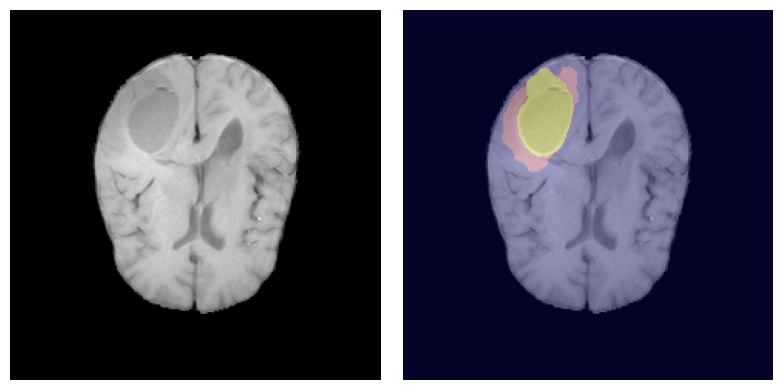

In [3]:
from utils import visualize_results

visualize_results(
    t1_file="data/t1n.nii.gz",
    segmentation_file="output/t1c_segmentation.nii.gz",
)

### Multiple input modalities and other available outputs

AURORA also supports different combinations of multi-modal MRI files (see manuscript). It will automatically select a suitable model depending on the inputs supplied.

- Any of the following combination of sequences can be supplied: 
    - T1-CE + T1 + T2 + T2-FLAIR
    - T1-CE only
    - T1 only
    - T2-FLAIR only
    - T1-CE + T2-FLAIR
    - T1-CE + T1
    - T1-CE + T1 + T2-FLAIR
- Instead of only saving the final output consisting of one file with 2 labels, additional files with labels for the whole lesion (metastasis + edema) or the metastasis only can also be saved.
- Test-time augmentation can be enabled (tta parameter in config, default = True). Segmentation with TTA will take around 10 times longer than without TTA.

The example below shows how to perform the inference using multi-modal inputs.

In [6]:
from brainles_aurora.inferer import AuroraGPUInferer, AuroraInferer, AuroraInfererConfig

config = AuroraInfererConfig()  # Use default config

# If you don-t have a GPU that supports CUDA use the CPU version: AuroraInferer(config=config)
inferer = AuroraGPUInferer(
    config=config,
)

# Use all four input modalities,we also create other outputs and a custom log file
_ = inferer.infer(
    t1="data/t1n.nii.gz",
    t1c="data/t1c.nii.gz",
    t2="data/t2w.nii.gz",
    fla="data/t2f.nii.gz",
    segmentation_file="output/multi-modal_segmentation.nii.gz",
    # The unbinarized network outputs for the whole tumor channel (edema + enhancing tumor core + necrosis) channel
    whole_tumor_unbinarized_floats_file="output/whole_tumor_unbinarized_floats.nii.gz",
    # The unbinarized network outputs for the metastasis (tumor core) channel
    metastasis_unbinarized_floats_file="output/metastasis_unbinarized_floats.nii.gz",
    log_file="output/custom_logfile.log",
)

2024-02-04 11:01:17 INFO: Initialized AuroraGPUInferer with config: AuroraInfererConfig(log_level=20, tta=True, sliding_window_batch_size=1, workers=0, threshold=0.5, sliding_window_overlap=0.5, crop_size=(192, 192, 32), model_selection=<ModelSelection.BEST: 'best'>)
2024-02-04 11:01:17 INFO: Set torch device: cuda
2024-02-04 11:01:17 INFO: Infer with config: AuroraInfererConfig(log_level=20, tta=True, sliding_window_batch_size=1, workers=0, threshold=0.5, sliding_window_overlap=0.5, crop_size=(192, 192, 32), model_selection=<ModelSelection.BEST: 'best'>) and device: cuda
2024-02-04 11:01:17 INFO: Successfully validated input images. Input mode: NIFTI_FILEPATH
2024-02-04 11:01:17 INFO: Received files: T1: True, T1C: True, T2: True, FLAIR: True
2024-02-04 11:01:17 INFO: Inference mode: t1-t1c-t2-fla
2024-02-04 11:01:17 INFO: No loaded compatible model found. Loading Model and weights


BasicUNet features: (32, 32, 64, 128, 256, 32).


2024-02-04 11:01:17 INFO: Setting up Dataloader
/home/florian/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
2024-02-04 11:01:17 INFO: Running inference on device := cuda
2024-02-04 11:01:19 INFO: Applying test time augmentations
2024-02-04 11:01:47 INFO: Post-processing data
2024-02-04 11:01:47 INFO: Saving post-processed data as NIFTI files
2024-02-04 11:01:48 INFO: Saved segmentation to output/multi-modal_segmentation.nii.gz
2024-02-04 11:01:48 INFO: Saved whole_network to output/whole_tumor_unbinarized_floats.nii.gz
2024-02-04 11:01:48 INFO: Saved metastasis_network to output/metastasis_unbinarized_floats.nii.gz
2024-02-04 11:01:48 INFO: Returning post-processed data as Dict of Numpy ar

### NumPy Inputs/ Outputs

In [11]:
from brainles_aurora.inferer import (
    AuroraGPUInferer,
    AuroraInferer,
    AuroraInfererConfig,
)
import nibabel as nib
import numpy as np

config = AuroraInfererConfig()


# AuroraInferer(config=config) # If you don-t have a GPU that supports CUDA use the CPU version (uncomment this and comment the GPU inferer)
inferer = AuroraGPUInferer(config=config)

# we load the nifty data to a numpy array
t1_np = nib.load("data/t1n.nii.gz").get_fdata()

# we can now use the inferer to perform the inference and obtain again a numpy array containing the segmentation
results = inferer.infer(t1=t1_np)
print([f"{k} : {v.shape}" for k, v in results.items()])

2024-02-04 11:05:09 INFO: Initialized AuroraGPUInferer with config: AuroraInfererConfig(log_level=20, tta=True, sliding_window_batch_size=1, workers=0, threshold=0.5, sliding_window_overlap=0.5, crop_size=(192, 192, 32), model_selection=<ModelSelection.BEST: 'best'>)
2024-02-04 11:05:09 INFO: Set torch device: cuda


2024-02-04 11:05:09 INFO: Infer with config: AuroraInfererConfig(log_level=20, tta=True, sliding_window_batch_size=1, workers=0, threshold=0.5, sliding_window_overlap=0.5, crop_size=(192, 192, 32), model_selection=<ModelSelection.BEST: 'best'>) and device: cuda
2024-02-04 11:05:09 INFO: Successfully validated input images. Input mode: NP_NDARRAY
2024-02-04 11:05:09 INFO: Received files: T1: True, T1C: False, T2: False, FLAIR: False
2024-02-04 11:05:09 INFO: Inference mode: t1-o
2024-02-04 11:05:09 INFO: No loaded compatible model found. Loading Model and weights


BasicUNet features: (32, 32, 64, 128, 256, 32).


2024-02-04 11:05:10 INFO: Setting up Dataloader
2024-02-04 11:05:10 INFO: Running inference on device := cuda
2024-02-04 11:05:11 INFO: Applying test time augmentations
2024-02-04 11:05:33 INFO: Post-processing data
2024-02-04 11:05:33 INFO: Returning post-processed data as Dict of Numpy arrays
2024-02-04 11:05:33 INFO: Finished inference 



['segmentation : (240, 240, 155)', 'whole_network : (240, 240, 155)', 'metastasis_network : (240, 240, 155)']


In [12]:
# now we can use the capabilities of numpy without having to re-read a nifti file, for example we could compute the number of non-tumor voxels as follows:
non_tumor_voxels = results["segmentation"] == 0
print("non-tumor voxels:", np.count_nonzero(non_tumor_voxels))

non-tumor voxels: 8834339
